# Neural network 
Simple one layer neural network classifier. Mathjax formula not fully supported in github, hence the formulas get corrupted.

<img src="image/nn_diagram.png" align="left">

<img src="image/nn_functions.png" align="left">

# Setup

## Python path
Python path setup to avoid the relative imports.

In [1]:
import sys
import os 

## Package dependencies

In [2]:
import inspect
import numpy as np
import matplotlib.pyplot as plt

## Jupyter notebook

In [3]:
np.set_printoptions(threshold=sys.maxsize)

## Network geometry

In [4]:
N = 1    # Batch size
D = 3    # Number of features in the input data
M = 2    # Number of nodes in a layer

---

# Confiurations 

## X

In [5]:
from data.classifications import (
    linear_separable
)
X, T, V = linear_separable(d=2, n=100)

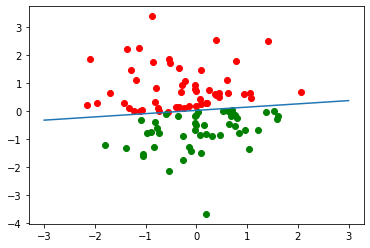

In [6]:
plt.scatter(X[T==0, 1], X[T==0, 2], c='red')
plt.scatter(X[T==1, 1], X[T==1, 2], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
plt.plot(x, y)

## T
Labels for data X.

### For One Hot Encoding labels
$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \; \dots \;, \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (N,M) }{ T_{_{OHE}} } = ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### For index labels
$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \qquad \text {for index labels }
\end{align*}
$

## W
Weight parameters.

In [7]:
from common.weights import (
    xavier,
    he,
    uniform
)

---

# Matmul layer

In [8]:
from layer.matmul import Matmul

## Objective Function
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

## Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Objective function
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [9]:
from layer import SoftmaxWithLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == float), \
        "X must be float or ndarray(dtype=float)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)   # オーバーフロー対策
    exp = np.exp(X - C)
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("softmax(): X %s exp %s P %s", X, exp, P)

    return P



## Objective function
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

### Gradient from cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


###  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [10]:
from common import (
    cross_entropy_log_loss,
    OFFSET_FOR_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        offset: float = OFFSET_FOR_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Assumption:
        Label is integer 0 or 1 for an OHE label and any integer for an index label.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

    Args:
        P: probabilities of shape (N,M) from soft-max layer where:
            N is Batch size
            M is Number of nodes
        T: label either in OHE format of shape (N,M) or index format of shape (N,).
           OHE: One Hot Encoding
        offset: small number to avoid np.inf by log(0) by log(0+offset)
    Returns:
        J: Loss value of shape (N,), a loss value per batch.
    """
    P, T = transform_X_T(P, T)

    # --------------------------------------------------------------------------------
    #

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [11]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [12]:
dJ = np.ones(N) / N
dJ

array([1.])

---


# Gradient check

* [two_layer_net.ipynb defines the lambda with parameter W which is redundant #254](https://github.com/cs231n/cs231n.github.io/issues/254)

The ```numerical_jacobian(f, X)``` returns ```J``` of the same shape with ```X```. It takes each element in ```x``` in ```X```, and calculate ```(f(x+h) and f(x-h))/2h```. For ```cross_entropy_logg_loss()```, the expected numerical gradient is ```gn = (-np.log(p+h+e) + -np.log(p-h+e)) / (2*h)``` for each element ```p``` in ```P```. 

In [13]:
from common import (
    numerical_jacobian,
    OFFSET_FOR_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: float = OFFSET_FOR_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that has the same shape of X.
    """
    X = np.array(X, dtype=float) if isinstance(X, (float, int)) else X
    J = np.zeros_like(X, dtype=float)

    # --------------------------------------------------------------------------------
    # (x+h) or (x-h) may cause an invalid value area for the function f.
    # e.g log loss tries to offset x=0 by adding a small value k as log(0+k).
    # Howev

In [14]:
# --------------------------------------------------------------------------------
# Example gradients for the cross entropy log loss -t*log(p).
# --------------------------------------------------------------------------------
p =0.86270721
h = OFFSET_FOR_DELTA
e = OFFSET_FOR_LOG

expected_gn = (-np.log(p+h+e) + np.log(p-h+e)) / (2*h)
actual_gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
print(f"Expected numerical gradient={expected_gn}")
print(f"Actual numerical gradient={actual_gn}")
print(f"Expected analytical gradient -T/P={-1 / (p+e)}")

Expected numerical gradient=-1.1591403356603358
Actual numerical gradient=-1.1591403356603358
Expected analytical gradient -T/P=-1.1591403356251433


In [15]:
p = 0.50924298 
gn = (cross_entropy_log_loss(p+h, 1) - cross_entropy_log_loss(p-h, 1)) / (2*h)
gn

-1.9636948946355481

In [16]:
1/0.50924298 

1.9636991363140637

In [17]:
from common import softmax

In [18]:
def gn():
    fx1 = cross_entropy_log_loss(softmax(np.array([1.85268148+h+e, 1.13995837])), 1)
    fx2 = cross_entropy_log_loss(softmax(np.array([1.85268148-h+e, 1.13995837])), 1)
    return (fx1 - fx2) / (2*h)

gn()

array([0.67100059])

In [29]:
X = np.array([-1.01277135, 0.5444011])
T = np.array([0, 1])
b = cross_entropy_log_loss(softmax(X), T)
print(b)
X2 = np.array([-1.01277135+h, 0.5444011])
X3 = np.array([-1.01277135-h, 0.5444011])
gn = (cross_entropy_log_loss(softmax(X2), T) - cross_entropy_log_loss(softmax(X3), T)) / (2*h)
print(gn)

objective = lambda x: cross_entropy_log_loss(softmax(x), T)
gn1 = numerical_jacobian(objective, X)

gn2 = numerical_jacobian(objective, X.reshape((1, -1)))
gn2

[0.19122305]
[0.17405252]


AssertionError: 